# Modeling (U-Nets) for DBSCAN Masks

Same exact implementation as step 4c.

In [1]:
# import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shapely.geometry
from sklearn.model_selection import train_test_split
import pickle

import h5py # just a safety check so the checkpoint callback doesnt crash
from scipy.misc import imresize
import tensorflow as tf
print(tf.__version__)

%matplotlib inline

1.2.0


# Dataset

In [2]:
dir_path = 'training_tiles_DBSCANv2/'
np_files = [os.path.join(path,f[:f.find('_img.npy')])
             for path,_,files in os.walk(dir_path) 
             for f in files if (f.endswith('img.npy'))]

In [3]:
def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image for display
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    
    for i in range(img.shape[2]):
        
        band = img[:, :, i]
        
        # Pick out the lower and upper percentiles
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        
        # Normalize the band
        band = (band - lower) / (upper - lower) * 255
        
        # Clip the high and low values, and cast to uint8
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
        
    return img_scaled

def resize(img, new_shape):
    img_resized = np.zeros(new_shape+(img.shape[2],)).astype('float32')
    for i in range(img.shape[2]):
        img_resized[:, :, i] = imresize(img[:, :, i], new_shape, interp='bicubic')
    return img_resized

def make_set(files, training_size, test_size,input_size):
    X=[]
    Y=[]
    maskz = []
    tile_to_use = np.random.choice(files, size=(training_size+test_size), replace=False)
    for tile_no in tile_to_use:
        img = np.load(tile_no +'_img.npy')
        img = resize(img, (input_size, input_size))
        
        mask = np.load(tile_no +'_mask.npy')
        mask = imresize(mask, (input_size, input_size))
        
        maskz = mask[..., None]
        #maskz = np.concatenate(mask[..., None], axis=2)
        
        X.append(img[None,...])
        Y.append(maskz[None,...])
    
    # Concatenate the results
    X = np.concatenate(X, axis = 0)
    Y = np.concatenate(Y, axis = 0)
    
    # Normalize the values
    X = X.astype('float32')
    X = (X / X.max() - 0.5) * 2   # put X in range [-1, 1]
    Y = Y.astype('float32') / 255 # put Y in range [0, 1]
    
    test_size = test_size/float(training_size+test_size)
    
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=test_size, random_state=42)
    
    return X_train, Y_train, X_val, Y_val

In [4]:
input_size = 256
X_train, Y_train, X_val, Y_val = make_set(np_files, 5000, 500, input_size)

/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [8]:
with open('X_val_DBSCANv2.pkl','wb') as f:
    pickle.dump(X_val,f)
with open('Y_val_DBSCANv2.pkl','wb') as f:
    pickle.dump(Y_val,f)

# U-Net 

In [10]:
# Source: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
import keras
from keras import backend as K
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from keras.models import Model
from keras.optimizers import Adam

# Set network size params
INPUT_SIZE = input_size
N_CLASSES = 1
N_CHANNEL = 3

# Define metrics
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Just put a negative sign in front of an accuracy metric to turn it into a loss to be minimized
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacc_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jacc_coef_loss(y_true, y_pred):
    return -jacc_coef(y_true, y_pred)

def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def get_unet(lr=0.001):
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.2)(pool1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.2)(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.2)(pool3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.2)(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # model.compile(optimizer=Adam(lr=lr), loss=jacc_coef_loss, metrics=[jacc_coef_int])
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[dice_coef])

    return model

In [11]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
# https://keras.io/callbacks/#reducelronplateau

# This sets the number of training epochs (you should do a lot more than 5)
NUM_EPOCHS = 60

# Define callback to save model checkpoints
if not os.path.exists('unet_checkpoints_DBSCANv2'):
    os.makedirs('unet_checkpoints_DBSCANv2')
model_checkpoint = ModelCheckpoint(os.path.join('unet_checkpoints_DBSCANv2', 'weights.{epoch:02d}-{val_loss:.5f}.hdf5'), monitor='loss', save_best_only=True)

# Define callback to reduce learning rate when learning stagnates
# This won't actually kick in with only 5 training epochs, but I'm assuming you'll train for hundreds of epochs when you get serious about training this NN.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, epsilon=0.002, cooldown=2)

# TensorBoard visuluaziations... this stuff is so freaking cool
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs8', histogram_freq=0, write_graph=True, write_images=True)

# Train the model
model = get_unet(0.001)
model.fit(X_train, Y_train, batch_size=32, epochs=NUM_EPOCHS, verbose=1, shuffle=True, 
          callbacks=[model_checkpoint, reduce_lr, tensorboard], validation_data=(X_val, Y_val))


Train on 5000 samples, validate on 500 samples
Epoch 1/60
5000/5000 [==============================] - 105s 21ms/step - loss: 0.2727 - jacc_coef_int: 0.1453 - val_loss: 0.2219 - val_jacc_coef_int: 0.3095
Epoch 2/60
5000/5000 [==============================] - 102s 20ms/step - loss: 0.2236 - jacc_coef_int: 0.3582 - val_loss: 0.2122 - val_jacc_coef_int: 0.3741
Epoch 3/60
5000/5000 [==============================] - 101s 20ms/step - loss: 0.2094 - jacc_coef_int: 0.4105 - val_loss: 0.2032 - val_jacc_coef_int: 0.4547
Epoch 4/60
5000/5000 [==============================] - 101s 20ms/step - loss: 0.1988 - jacc_coef_int: 0.4399 - val_loss: 0.2011 - val_jacc_coef_int: 0.4570
Epoch 5/60
5000/5000 [==============================] - 101s 20ms/step - loss: 0.1961 - jacc_coef_int: 0.4448 - val_loss: 0.2030 - val_jacc_coef_int: 0.4537
Epoch 6/60
5000/5000 [==============================] - 101s 20ms/step - loss: 0.1909 - jacc_coef_int: 0.4601 - val_loss: 0.1901 - val_jacc_coef_int: 0.4266
Epoch 7/60


KeyboardInterrupt: 

# View some output

In [12]:
K.clear_session()
model = None
import gc
gc.collect()

0

In [13]:
!ls unet_checkpoints_DBSCANv2/

weights.01-0.22191.hdf5  weights.18-0.16637.hdf5  weights.35-0.16530.hdf5
weights.02-0.21224.hdf5  weights.19-0.16711.hdf5  weights.36-0.16632.hdf5
weights.03-0.20323.hdf5  weights.20-0.16662.hdf5  weights.37-0.16621.hdf5
weights.04-0.20108.hdf5  weights.21-0.16573.hdf5  weights.38-0.16567.hdf5
weights.05-0.20300.hdf5  weights.22-0.17299.hdf5  weights.39-0.16898.hdf5
weights.06-0.19008.hdf5  weights.23-0.16475.hdf5  weights.40-0.17052.hdf5
weights.07-0.19174.hdf5  weights.24-0.15943.hdf5  weights.41-0.16880.hdf5
weights.08-0.20711.hdf5  weights.25-0.16145.hdf5  weights.42-0.17082.hdf5
weights.09-0.18430.hdf5  weights.26-0.15802.hdf5  weights.43-0.16882.hdf5
weights.10-0.18165.hdf5  weights.28-0.15964.hdf5  weights.44-0.17261.hdf5
weights.11-0.18376.hdf5  weights.29-0.16507.hdf5  weights.45-0.17024.hdf5
weights.13-0.17574.hdf5  weights.30-0.15723.hdf5  weights.46-0.17266.hdf5
weights.14-0.17847.hdf5  weights.31-0.15961.hdf5  weights.47-0.17181.hdf5
weights.15-0.18080.hdf5  weights.32-0.

In [14]:
# If you need to load the model, you can use these lines.  Change the weights filename to match one you have.
model = get_unet()
model.load_weights('unet_checkpoints_DBSCANv2/weights.33-0.15875.hdf5')

with open('X_val3.pkl','rb') as f:
    X_val = pickle.load(f)
with open('Y_val3.pkl','rb') as f:
    Y_val = pickle.load(f)

In [15]:
from sklearn.metrics import jaccard_similarity_score
# Function to create an iterator with examples
def jacc_coef_int(y_true, y_pred):
    y_pred_pos = y_pred
    intersection = np.sum(y_true * y_pred_pos)
    sum_ = np.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)
def get_examples():
    for i in range(Y_val.shape[0]):
        if Y_val[i, ...].sum() > 3000:
            X = X_val[i]
            Y = Y_val[i]
            yield X, Y

# Function to plot a single example
def plot_example(X, Y, model):
    # Apply the model to this example
    prediction = model.predict(X[None, ...])[0, ...] > 0.15
    prediction = prediction * 1
    
    fig, axes = plt.subplots(1, 3, figsize=(10,10))
    
    # Iterate through each target class
    for tno in range(1):
        targ = Y[:, :, tno]
        pred = prediction[:, :, tno]
        
        jaccard_score1 = jaccard_similarity_score(targ.astype('uint8'),pred.astype('uint8'))
        jaccard_score2 = jacc_coef_int(targ,pred)
        # plt.suptitle('Jaccard Sim (SKlearn): '+ str(jaccard_score1)+' | Jaccard Sim (Custom): '+ str(jaccard_score2),size=18)
        plt.suptitle('Jaccard Sim (Custom): '+ str(jaccard_score2),size=18,color='w')
        
        ax1, ax2, ax3 = axes[:]

        ax1.imshow(scale_bands(X[:, :, :])) # This index starts at 0, so I had to decrement
        ax2.imshow(targ, vmin=0, vmax=1, cmap=plt.cm.gray)
        ax3.imshow(pred, vmin=0, vmax=1, cmap=plt.cm.gray)
        
        ax1.set_title('Image',color='w')
        ax2.set_title('Ground Truth',color='w')
        ax3.set_title('Prediction',color='w')
        
        fig.tight_layout()
        plt.subplots_adjust(top=1.55)
    
    plt.show()

example_generator = get_examples()


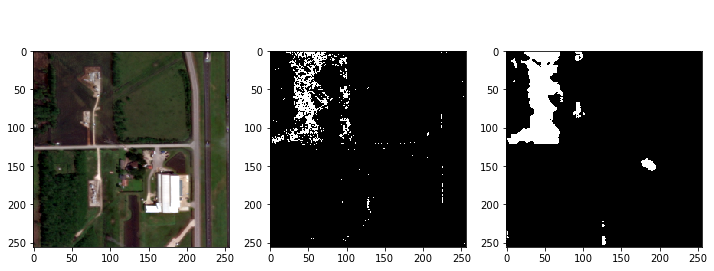

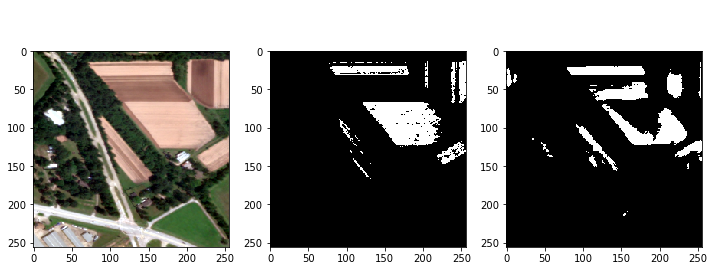

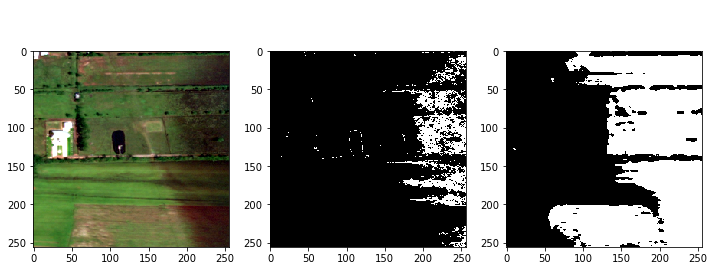

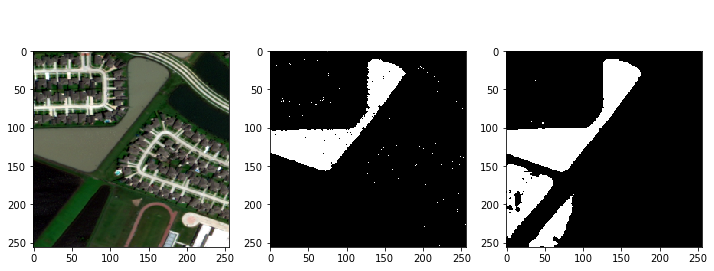

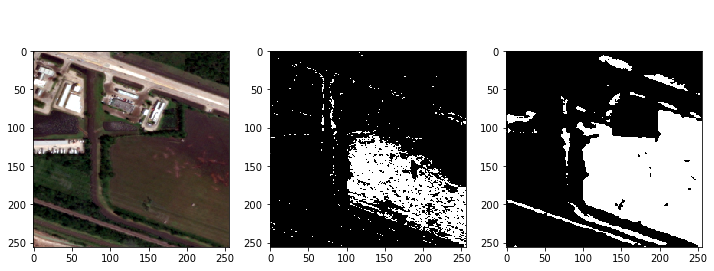

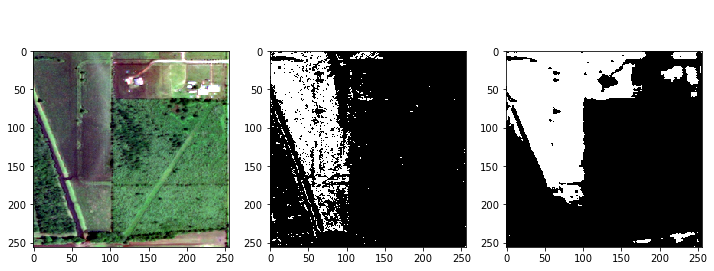

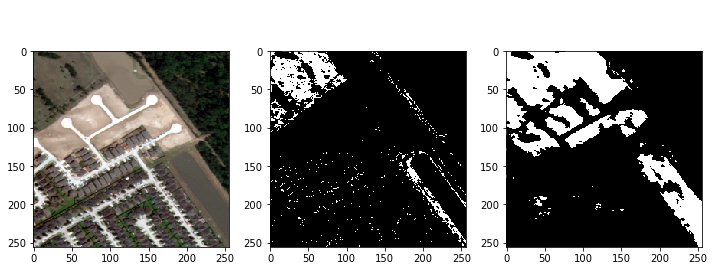

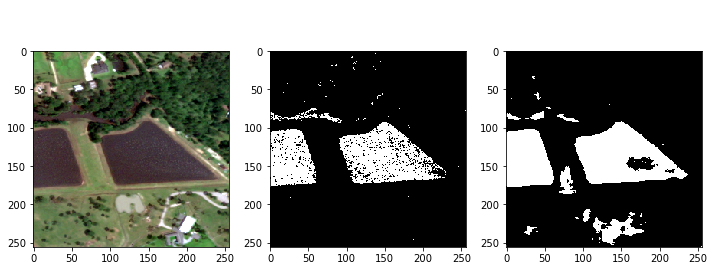

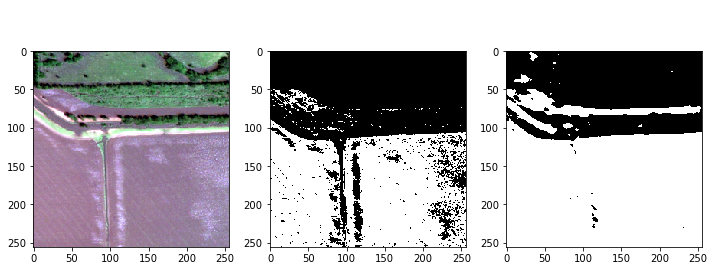

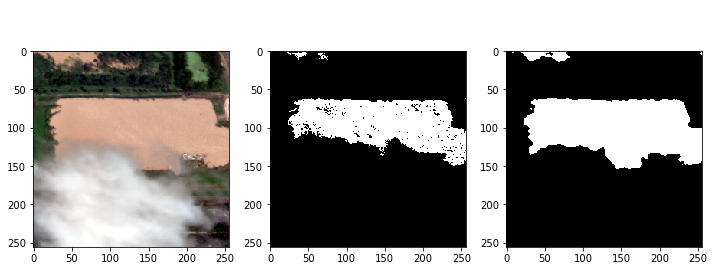

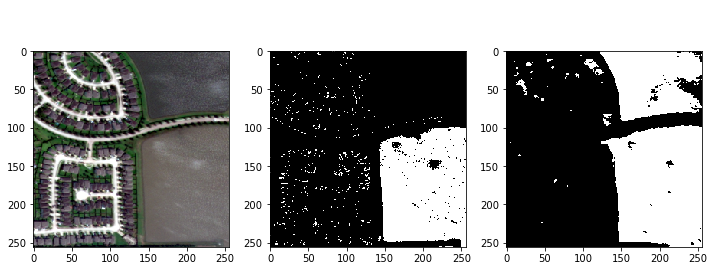

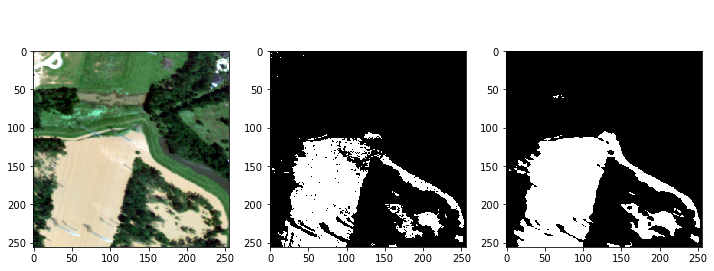

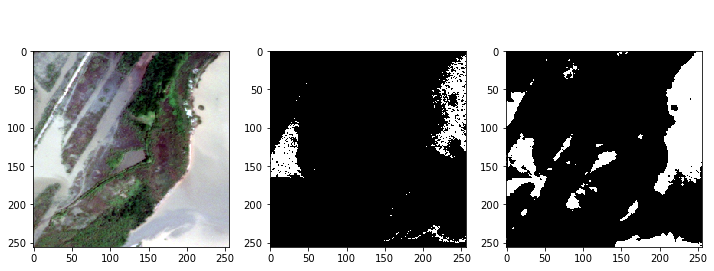

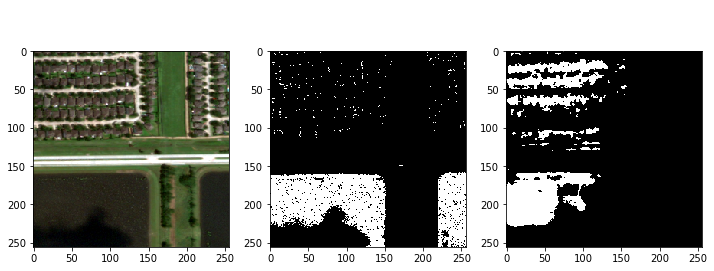

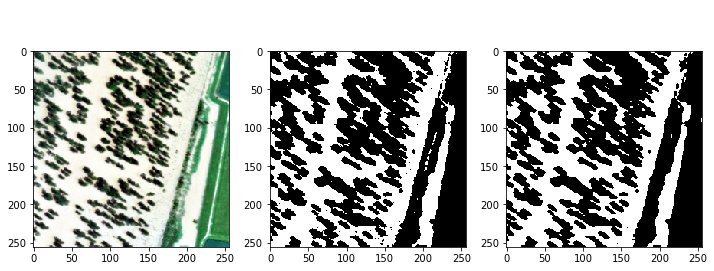

In [16]:
i = 0
while i < 15:
    X, Y = next(example_generator)
    plot_example(X, Y, model)
    i+= 1

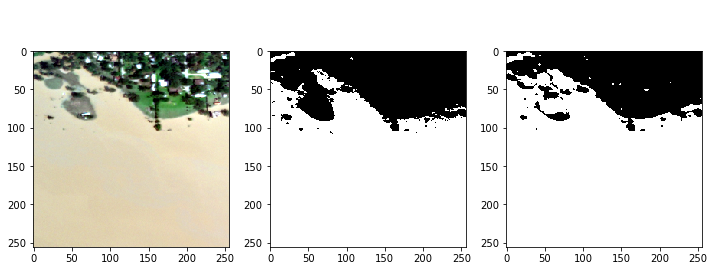

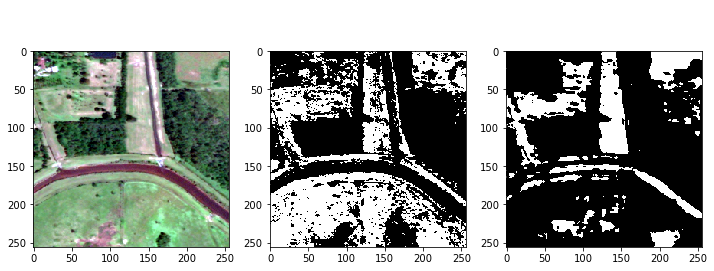

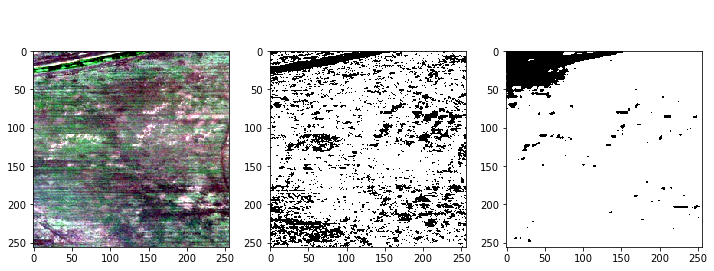

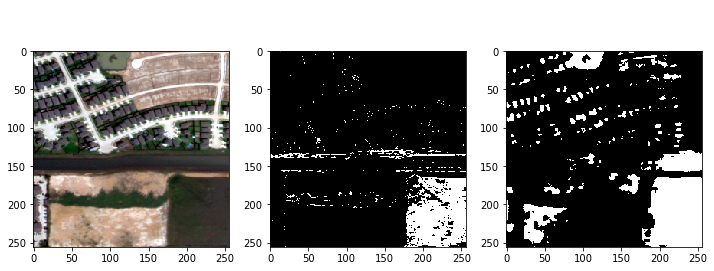

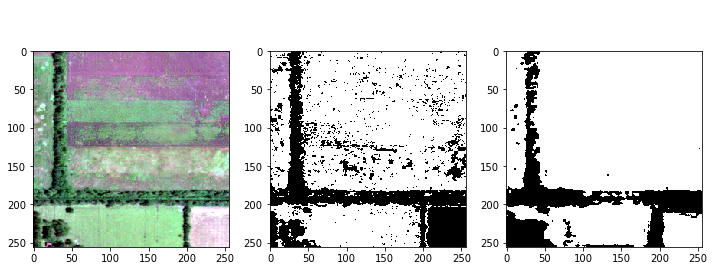

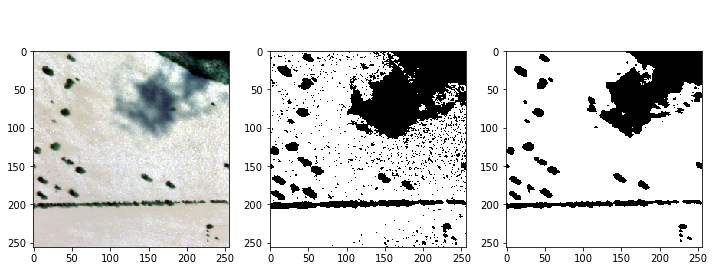

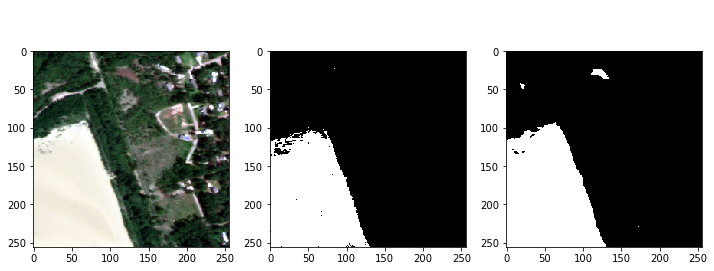

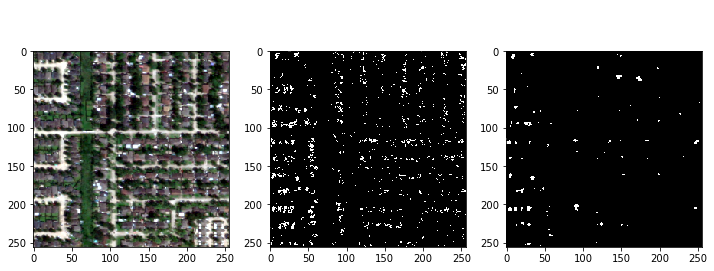

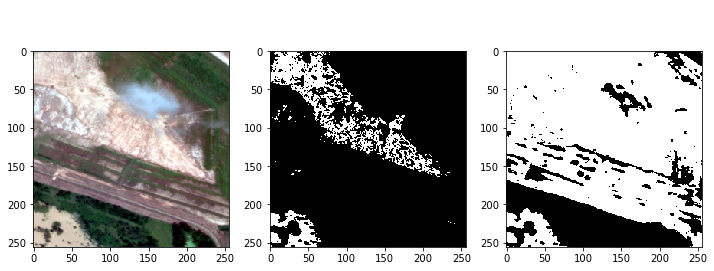

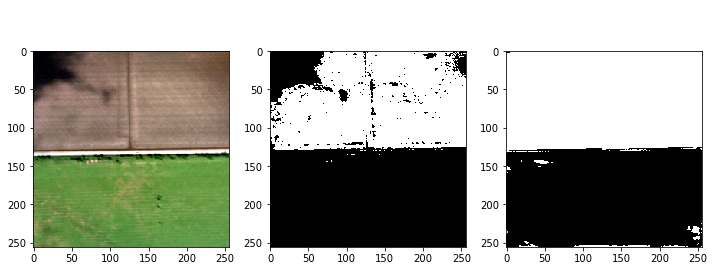

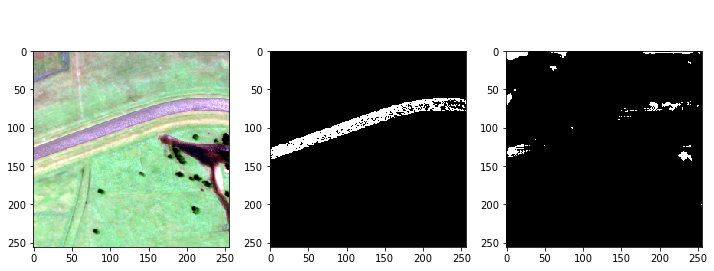

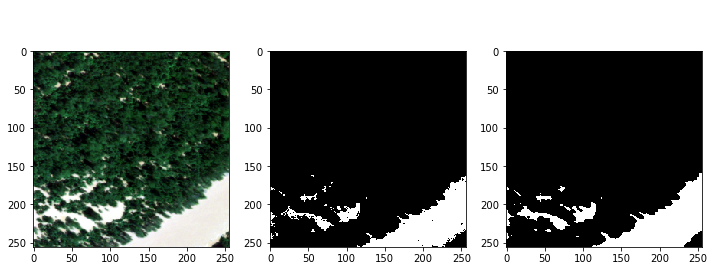

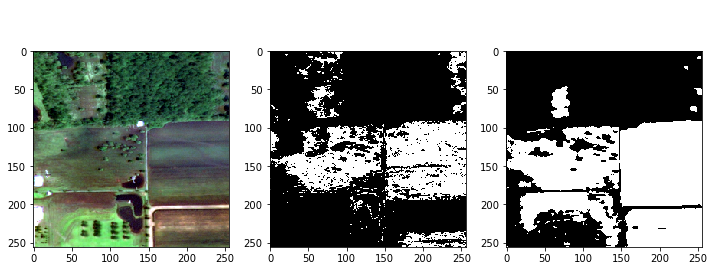

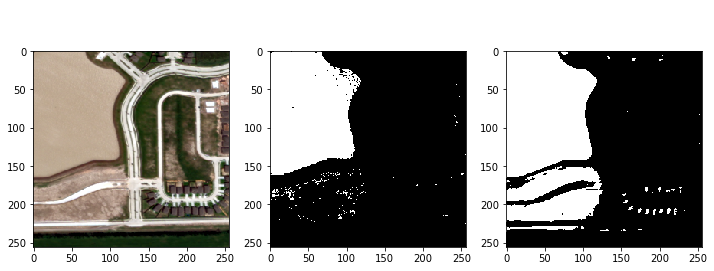

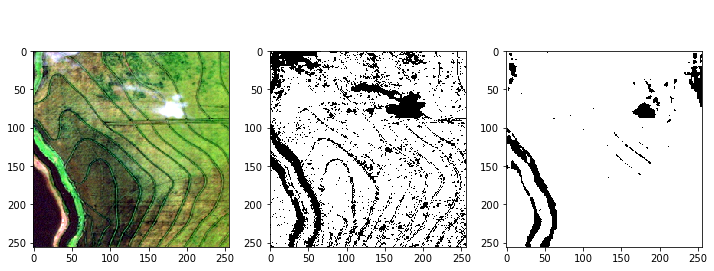

In [30]:
i = 0
while i < 15:
    X, Y = next(example_generator)
    plot_example(X, Y, model)
    i+= 1